In [1]:
# make sure you're logged in with \`huggingface-cli login\`
from diffusers import StableDiffusionParticleNFSDPipeline, LMSDiscreteScheduler, DDIMScheduler, DDPMScheduler, SDEScheduler, EulerDiscreteScheduler
import torch
import argparse
import os
from torchvision.utils import make_grid, save_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import lpips
import shutil
# import aesthetic_score
# import open_clip
# import clip

%load_ext autoreload
%autoreload 2

/home/nzilberstein/anaconda3/envs/stable-dif/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load SD-1.5

In [2]:
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

torch.cuda.set_device(0)

pipe = StableDiffusionParticleNFSDPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base")
# pipe = StableDiffusionParticleSDSPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda")

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

# load dino 
dino = torch.hub.load('facebookresearch/dino:main', 'dino_vits16').to("cuda")

# # load clip
# model, _, preprocess = open_clip.create_model_and_transforms('ViT-g-14', pretrained='laion2b_s12b_b42k')
# model2, _ = clip.load("ViT-L/14", device='cuda')  #RN50x64
# model = model.cuda().eval()
# model2 = model2.eval()
# tokenizer = open_clip.get_tokenizer('ViT-g-14')

# # load aesthetic model
# model_aes = aesthetic_score.MLP(768)  # CLIP embedding dim is 768 for CLIP ViT L 14
# s = torch.load("./clip-refs/sac+logos+ava1-l14-linearMSE.pth")   # load the model you trained previously or the model available in this repo
# model_aes.load_state_dict(s)
# model_aes.to("cuda")
# model_aes.eval()

Loading pipeline class <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_particle_NFSD.StableDiffusionParticleNFSDPipeline'> from /home/nzilberstein/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1-base/snapshots/5ede9e4bf3e3fd1cb0ef2f7a3fff13ee514fdf06
config_dict {'_class_name': 'StableDiffusionPipeline', '_diffusers_version': '0.10.0.dev0', 'feature_extractor': ['transformers', 'CLIPImageProcessor'], 'requires_safety_checker': False, 'safety_checker': [None, None], 'scheduler': ['diffusers', 'PNDMScheduler'], 'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer'], 'unet': ['diffusers', 'UNet2DConditionModel'], 'vae': ['diffusers', 'AutoencoderKL']}


Using cache found in /home/nzilberstein/.cache/torch/hub/facebookresearch_dino_main


# Define the prompt

In [3]:
# prompt = ["A tray of scissors is on a table with a lamp and candles"]
prompt = ["A plate piled high with chocolate chip cookies"]
neg_prompt = ['unrealistic, blurry, low quality, out of focus, ugly, low contrast, dull, dark, low-resolution, gloomy']
num_of_image = 4
prompt = prompt * num_of_image
neg_prompt = neg_prompt * num_of_image

In [4]:

seed = 6
# number of sampling steps
steps = 500
# guidance scale
w = 7.5

torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.random.manual_seed(seed)
# torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True


# Vanilla (i.i.d. sampling)

In [ ]:
generator = torch.Generator(device="cuda").manual_seed(seed)

out = pipe(prompt, generator=generator, num_inference_steps=steps, guidance_scale=w, output_type='tensor')
image = out.images
image_grid = make_grid(torch.from_numpy(image).permute(0, 3, 1, 2), nrow=int(np.sqrt(len(image))))
plt.imshow(image_grid.permute(1, 2, 0))

del out
torch.cuda.empty_cache()

# Particle Guidance (pixel)

0 4


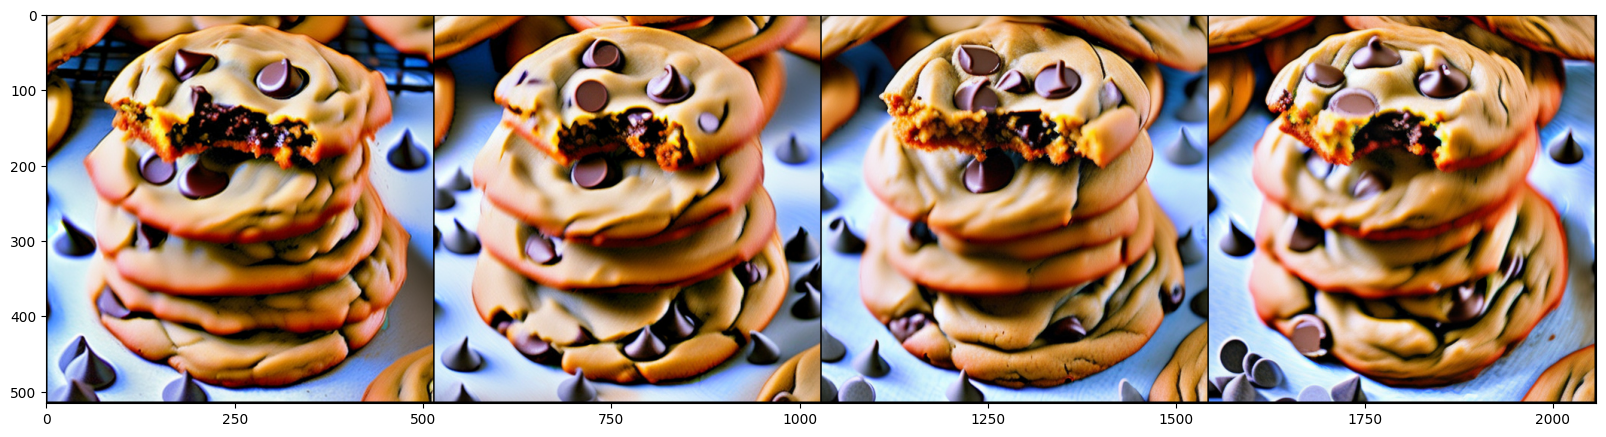

tensor(0.8961, device='cuda:0', grad_fn=<AddBackward0>)
1 4


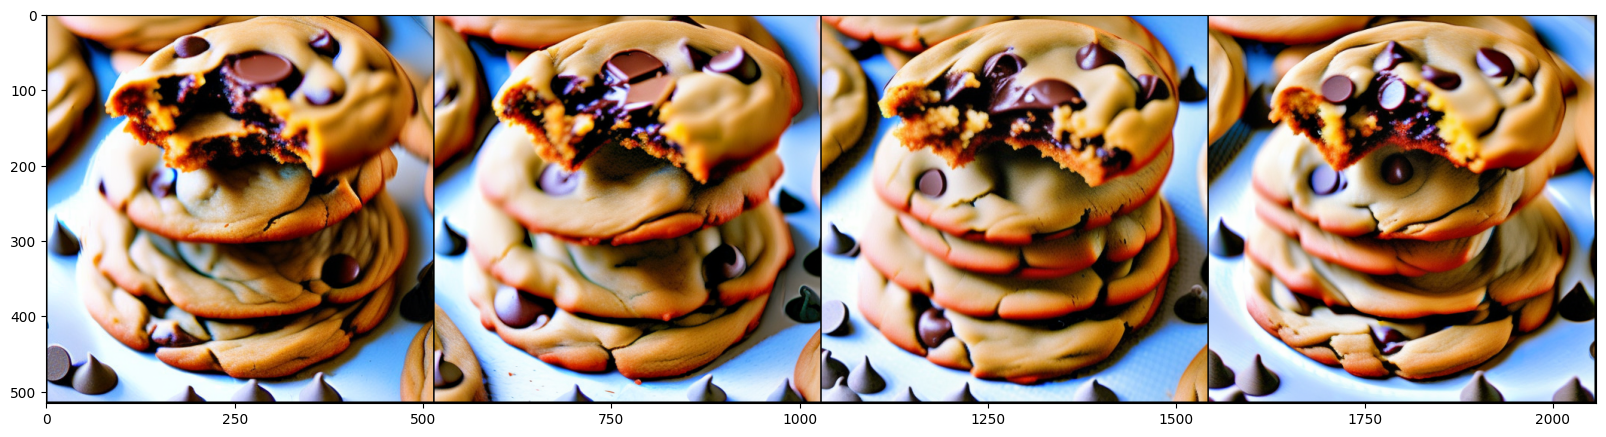

tensor(0.9154, device='cuda:0', grad_fn=<AddBackward0>)


In [20]:
list_of_images = []

generator = torch.Generator(device="cuda").manual_seed(seed)
# coefficient for the particle guidance scale 
coeff_list = [0, 1] #,  300, 500, 900] #0, 2, 5 similar
# coeff_list = [700, 900]
# lr_list = [0.015, 0.02]#, 0.05]
t_repul_list = [200]
lr = 0.012 #0.015 for 500 steps, 0.01 for 1ksteps
# coeff = 1000
it = 1
t_repul = 999

for coeff in coeff_list:
    # for t_repul in t_repul_list:   
    for svgd in [True]:   
        # Clean folder in /home/nicolas/RED-diff_stable/_exp/nfsd_stable_lpips before starting
        dir_evol = "/home/nzilberstein/red_diff_stsable/RED-diff_stable/_exp/nfsd_stable_dino"
        if os.path.exists(dir_evol):
            shutil.rmtree(dir_evol)
        os.makedirs(dir_evol)       

        neg_prompt = ['unrealistic, blurry, low quality, out of focus, ugly, low contrast, dull, dark, low-resolution, gloomy']
        neg_prompt = neg_prompt * num_of_image
        print(coeff, num_of_image)
        
        # out = pipe.dino(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, dino=dino, output_type='tensor')
        out = pipe(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, lr = lr, svgd=svgd, output_type='tensor', negative_prompt=neg_prompt, t_repul = t_repul) #0.4 for ADAM
        # out = pipe.dino_NFSD(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, dino=dino, lr = lr, output_type='tensor', negative_prompt = neg_prompt)
        images_DINO = out.images
        images_DINO = torch.from_numpy(images_DINO).permute(0, 3, 1, 2)
        image_grid = make_grid(images_DINO)
        list_of_images.append(image_grid)
        plt.figure(it, figsize=(20, 20))
        plt.imshow(image_grid.permute(1, 2, 0))
        plt.show()
        

        total_pair_wise_sim = 0.
        xo_list = dino(images_DINO.cuda())
        # del dino
        xo_list /= xo_list.norm(dim=-1, keepdim=True)
        # calculate the cosine similarity
        sim = (xo_list @ xo_list.T)
        # set the diagonal to be 0
        sim = sim - torch.diag(sim.diag())
        total_pair_wise_sim += sim.sum() / (sim.shape[0] * (sim.shape[0] - 1))
        print(total_pair_wise_sim)

        # torch.save(images_DINO, f'images_DINO_coef{coeff}_buda_.pt')

        del out 
        torch.cuda.empty_cache()
        it += 1

# Particle Guidance (dino feature space)

30 4
tensor(959, device='cuda:0')
tensor(759, device='cuda:0')
tensor(559, device='cuda:0')
tensor(359, device='cuda:0')
tensor(159, device='cuda:0')


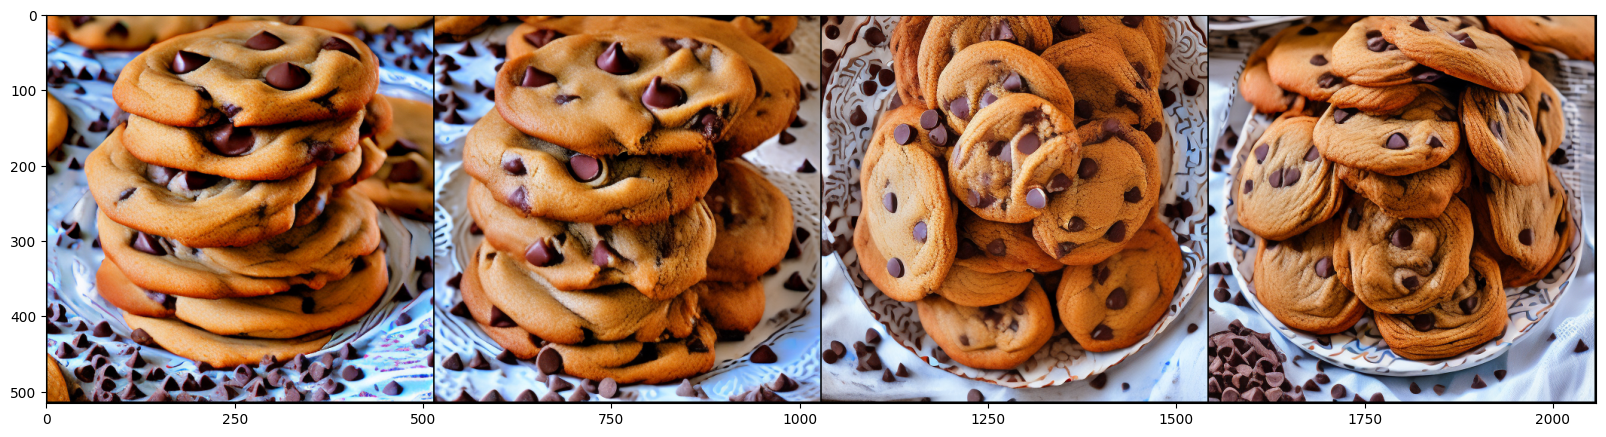

tensor(0.7606, device='cuda:0', grad_fn=<AddBackward0>)


In [21]:
generator = torch.Generator(device="cuda").manual_seed(seed)
# coefficient for the particle guidance scale 
coeff_list = [30] #,  300, 500, 900] #0, 2, 5 similar
# coeff_list = [700, 900]
# lr_list = [0.015, 0.02]#, 0.05]
t_repul_list = [999]
lr = 0.015 #0.015 for 500 steps, 0.01 for 1ksteps
# coeff = 1000
it = 1

for coeff in coeff_list:
    for t_repul in t_repul_list:   
# for lr in lr_list:
        # Clean folder in /home/nicolas/RED-diff_stable/_exp/nfsd_stable_lpips before starting
        dir_evol = "/home/nzilberstein/red_diff_stable/RED-diff_stable/_exp/nfsd_stable_dino"
        if os.path.exists(dir_evol):
            shutil.rmtree(dir_evol)
        os.makedirs(dir_evol)

        neg_prompt = ['unrealistic, blurry, low quality, out of focus, ugly, low contrast, dull, dark, low-resolution, gloomy']
        neg_prompt = neg_prompt * num_of_image
        print(coeff, num_of_image)
        
        # out = pipe.dino(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, dino=dino, output_type='tensor')
        out = pipe.dino_NFSD(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, dino=dino,  lr = lr, output_type='tensor', negative_prompt=neg_prompt, t_repul = t_repul) #0.4 for ADAM
        # out = pipe.dino_NFSD(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, dino=dino, lr = lr, output_type='tensor', negative_prompt = neg_prompt)
        images_DINO = out.images
        images_DINO = torch.from_numpy(images_DINO).permute(0, 3, 1, 2)
        save_image(images_DINO, f'/home/nzilberstein/red_diff_stable/RED-diff_stable/_exp/nfsd_outputs_paper/cookies_trepul_{t_repul}_coeff_{coeff}.pdf')
        image_grid = make_grid(images_DINO)
        list_of_images.append(image_grid)
        plt.figure(it, figsize=(20, 20))
        plt.imshow(image_grid.permute(1, 2, 0))
        plt.show()
        

        total_pair_wise_sim = 0.
        xo_list = dino(images_DINO.cuda())
        # del dino
        xo_list /= xo_list.norm(dim=-1, keepdim=True)
        # calculate the cosine similarity
        sim = (xo_list @ xo_list.T)
        # set the diagonal to be 0
        sim = sim - torch.diag(sim.diag())
        total_pair_wise_sim += sim.sum() / (sim.shape[0] * (sim.shape[0] - 1))
        print(total_pair_wise_sim)
        # torch.save(images_DINO, f'images_DINO_coef{coeff}_buda_.pt')

        del out
        torch.cuda.empty_cache()
        it += 1

# 0.86 for 500 steps

In [22]:
grid = make_grid(list_of_images, nrow=1)
save_image(grid, os.path.join('/home/nzilberstein/Inverse/_exp', 'cookies_SVGD.pdf'))

# Particle LPIPS

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/nicolas/anaconda3/envs/stable-dif/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
30 4
tensor(999, device='cuda:0')
tensor(799, device='cuda:0')
tensor(599, device='cuda:0')
tensor(399, device='cuda:0')
tensor(199, device='cuda:0')


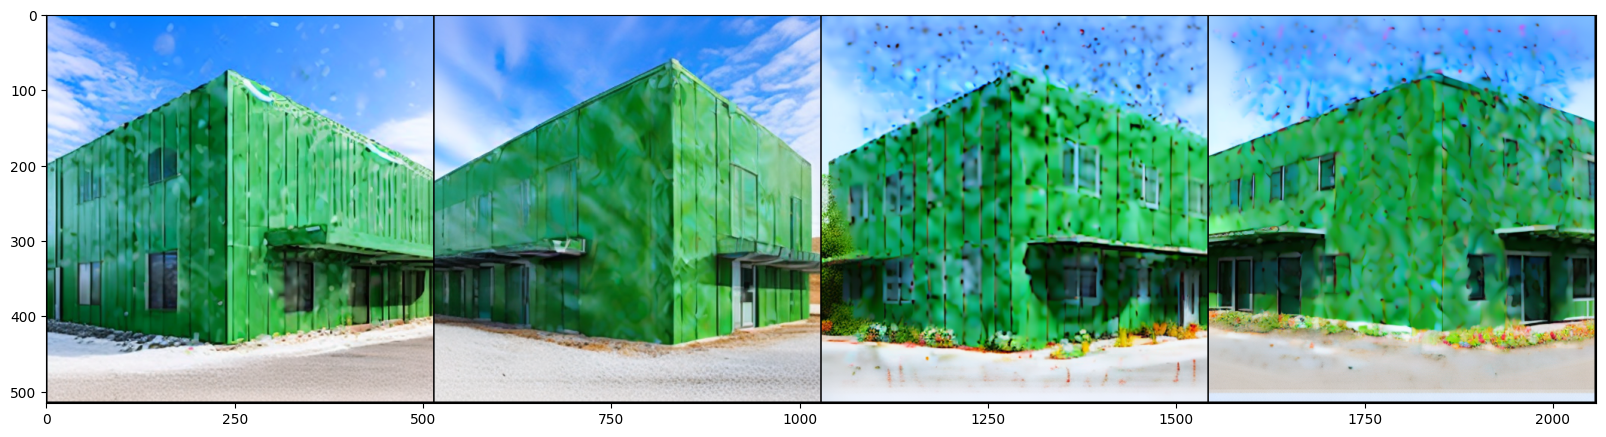

tensor(0.7641, device='cuda:0', grad_fn=<AddBackward0>)
10 4
tensor(999, device='cuda:0')


KeyboardInterrupt: 

In [11]:
generator = torch.Generator(device="cuda").manual_seed(seed)
# coefficient for the particle guidance scale
coeff_list = [10, 30, 50, 100]
t_repul = 800
lr = 0.015
# coeff = 30
it = 1
lpips_ = lpips.LPIPS(net='alex').cuda() # best forward score

# Clean folder in /home/nicolas/RED-diff_stable/_exp/nfsd_stable_lpips before starting
dir_evol = "/home/nicolas/RED-diff_stable/_exp/nfsd_stable_lpips"
if os.path.exists(dir_evol):
    shutil.rmtree(dir_evol)
os.makedirs(dir_evol)

for coeff in coeff_list:   

    # out = pipe.dino(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, dino=dino, output_type='tensor')
    neg_prompt = ['unrealistic, blurry, low quality, out of focus, ugly, low contrast, dull, dark, low-resolution, gloomy']
    neg_prompt = neg_prompt * num_of_image
    print(coeff, num_of_image)
    # out = pipe.dino(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, dino=dino, output_type='tensor')
    out = pipe.lpips_NFSD(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, lpips=lpips_, lr = lr, output_type='tensor', negative_prompt=neg_prompt, t_repul = t_repul) #0.4 for ADAM
    images_lpips = out.images
    image_grid = make_grid(torch.from_numpy(images_lpips).permute(0, 3, 1, 2))
    plt.figure(it, figsize=(20, 20))
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.show()

    total_pair_wise_sim = 0.
    xo_list = dino(torch.from_numpy(images_lpips).permute(0, 3, 1, 2).cuda())
    # del dino
    xo_list /= xo_list.norm(dim=-1, keepdim=True)
    # calculate the cosine similarity
    sim = (xo_list @ xo_list.T)
    # set the diagonal to be 0
    sim = sim - torch.diag(sim.diag())
    total_pair_wise_sim += sim.sum() / (sim.shape[0] * (sim.shape[0] - 1))
    print(total_pair_wise_sim)

    del out
    torch.cuda.empty_cache()
    it += 1